<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Head-On Black Hole Collision

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module implements a basic numerical relativity code to merge two black holes in *spherical coordinates*

### Here we place the black holes initially on the $z$-axis, so the entire simulation is axisymmetric about the $\phi$-axis. Not sampling in the $\phi$ direction greatly speeds up the simulation.

**Notebook Status:** <font color = green><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution *after a short numerical evolution of the initial data* (see [plots at bottom](#convergence)), and all quantities have been validated against the [original SENR code](https://bitbucket.org/zach_etienne/nrpy).

### NRPy+ Source Code for this module: 
* [BSSN/BrillLindquist.py](../edit/BSSN/BrillLindquist.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb): Brill-Lindquist initial data; sets all ADM variables in Cartesian basis: 
* [BSSN/ADM_Exact_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Exact_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Exact_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): Spherical/Cartesian ADM$\to$Curvilinear BSSN converter function, for which exact expressions are given for ADM quantities.
* [BSSN/BSSN_ID_function_string.py](../edit/BSSN/BSSN_ID_function_string.py): Sets up the C code string enabling initial data be set up in a point-by-point fashion
* [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
* [BSSN/BSSN_RHSs.py](../edit/BSSN/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb): Generates the right-hand sides for the BSSN evolution equations in singular, curvilinear coordinates
* [BSSN/BSSN_gauge_RHSs.py](../edit/BSSN/BSSN_gauge_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb): Generates the right-hand sides for the BSSN gauge evolution equations in singular, curvilinear coordinates

## Introduction:
Here we use NRPy+ to generate the C source code necessary to set up initial data for two black holes (Brill-Lindquist, [Brill & Lindquist, Phys. Rev. 131, 471, 1963](https://journals.aps.org/pr/abstract/10.1103/PhysRev.131.471); see also Eq. 1 of [Brandt & Brügmann, arXiv:gr-qc/9711015v1](https://arxiv.org/pdf/gr-qc/9711015v1.pdf)). Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on an [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4 is chosen below, but multiple options exist). 

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration
    * [**NRPy+ tutorial on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on Brill-Lindquist initial data**](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb)
    * [**NRPy+ tutorial on validating Brill-Lindquist initial data**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_Exact_Initial_Data.ipynb).
1. Next, integrate the initial data forward in time using the Method of Lines coupled to a Runge-Kutta explicit timestepping algorithm:
    1. At the start of each iteration in time, output the Hamiltonian constraint violation 
        * [**NRPy+ tutorial on BSSN constraints**](Tutorial-BSSN_constraints.ipynb).
    1. At each RK time substep, do the following:
        1. Evaluate BSSN RHS expressions 
            * [**NRPy+ tutorial on BSSN right-hand sides**](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb) ([**BSSN Introduction Notebook**](Tutorial-BSSN_formulation.ipynb))
            * [**NRPy+ tutorial on BSSN gauge condition right-hand sides**](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb) 
        1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
            * [**NRPy+ tutorial on setting up singular, curvilinear boundary conditions**](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)
        1. Enforce constraint on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ 
            * [**NRPy+ tutorial on enforcing $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint**](Tutorial-BSSN-Enforcing_Determinant_gammabar_equals_gammahat_Constraint.ipynb)
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
    1. [Step 1.a](#cfl) Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 2](#adm_id): Import Brill-Lindquist ADM initial data C function from the [`BSSN.BrillLindquist`](../edit/BSSN/BrillLindquist.py) NRPy+ module
1. [Step 3](#bssn): Output C code for BSSN spacetime solve
    1. [Step 3.a](#bssnrhs): Output C code for BSSN RHS expressions
    1. [Step 3.b](#hamconstraint): Output C code for Hamiltonian constraint
    1. [Step 3.c](#enforce3metric): Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint
    1. [Step 3.d](#ccodegen): Generate C code kernels for BSSN expressions, in parallel if possible
    1. [Step 3.e](#cparams_rfm_and_domainsize): Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
1. [Step 4](#bc_functs): Set up boundary condition functions for chosen singular, curvilinear coordinate system
1. [Step 5](#mainc): `BrillLindquist_Playground.c`: The Main C Code
1. [Step 6](#compileexec): Compile generated C codes & perform the black hole collision calculation
1. [Step 7](#visualize): Visualize the output!
    1. [Step 7.a](#installdownload): Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded
    1. [Step 7.b](#genimages): Generate images for visualization animation
    1. [Step 7.c](#genvideo): Generate visualization animation
1. [Step 8](#convergence): Plot the numerical error, and confirm that it converges to zero with increasing numerical resolution (sampling)
1. [Step 9](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import lhrh,outCfunction,outC_function_dict # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys, time     # Standard Python modules for multiplatform OS-level functions, benchmarking
import pickle                    # Standard Python module for bytewise transfer of data between modules

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("BSSN_Two_BHs_Collide_Ccodes/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

# Step 1: Set the spatial dimension parameter
#         to three (BSSN is a 3+1 decomposition
#         of Einstein's equations), and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 1.a: Enable SIMD-optimized code?
#           I.e., generate BSSN and Ricci C code kernels using SIMD-vectorized
#           compiler intrinsics, which *greatly improve the code's performance*,
#           though at the expense of making the C-code kernels less
#           human-readable.
#           * Important note in case you wish to modify the BSSN/Ricci kernels
#             here by adding expressions containing transcendental functions
#             (e.g., certain scalar fields):
#           Note that SIMD-based transcendental function intrinsics are not
#           supported by the default installation of gcc or clang (you will
#           need to use e.g., the SLEEF library from sleef.org, for this
#           purpose). The Intel compiler suite does support these intrinsics
#           however without the need for external libraries.
SIMD_enable = True

# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Spherical"

# Step 2.a: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size     = 7.5 # Needed for all coordinate systems.

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05 # If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.b: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4           # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double"    # Best to use double here.
default_CFL_FACTOR= 0.5 # (GETS OVERWRITTEN WHEN EXECUTED.) In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.

# Step 3: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 3-step process:
#       3.A: Evaluate RHSs (RHS_string)
#       3.B: Apply boundary conditions (post_RHS_string, pt 1)
#       3.C: Enforce det(gammabar) = det(gammahat) constraint (post_RHS_string, pt 2)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method,
    RHS_string      = """
Ricci_eval(&rfmstruct, &params, RK_INPUT_GFS, auxevol_gfs);
rhs_eval(&rfmstruct, &params, auxevol_gfs, RK_INPUT_GFS, RK_OUTPUT_GFS);""",
    post_RHS_string = """
apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_OUTPUT_GFS);
enforce_detgammabar_constraint(&rfmstruct, &params,                     RK_OUTPUT_GFS);\n""",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

# Step 4: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Step 5: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)
FD_functions_enable = True
par.set_parval_from_str("finite_difference::FD_functions_enable", FD_functions_enable)

# Step 6: If SIMD_enable==True, then copy SIMD/SIMD_intrinsics.h to $Ccodesdir/SIMD/SIMD_intrinsics.h
#         Otherwise just paste a #define SIMD_IS_DISABLED to that file.
cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
if SIMD_enable == True:
    shutil.copy(os.path.join("SIMD","SIMD_intrinsics.h"),os.path.join(Ccodesdir,"SIMD/"))
else:
    with open(os.path.join(Ccodesdir,"SIMD","SIMD_intrinsics.h"), "w") as file:
        file.write("#define SIMD_IS_DISABLED\n")

# Step 7: Set the direction=2 (phi) axis to be the symmetry axis; i.e.,
#         axis "2", corresponding to the i2 direction.
#      This sets all spatial derivatives in the phi direction to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","2")

<a id='cfl'></a>

## Step 1.a: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [2]:
# Output the find_timestep() function to a C file.
rfm.out_timestep_func_to_file(os.path.join(Ccodesdir,"find_timestep.h"))

In [3]:
# In the parallel C codegen below, the
def pickled_outC_function_dict(outC_function_dict):
    outstr = []
    outstr.append(pickle.dumps(len(outC_function_dict)))
    for Cfuncname, Cfunc in outC_function_dict.items():
        outstr.append(pickle.dumps(Cfuncname))
        outstr.append(pickle.dumps(Cfunc))
    return outstr

<a id='adm_id'></a>

# Step 2: Import Brill-Lindquist ADM initial data C function from the [`BSSN.BrillLindquist`](../edit/BSSN/BrillLindquist.py) NRPy+ module \[Back to [top](#toc)\]
$$\label{adm_id}$$

The [`BSSN.BrillLindquist`](../edit/BSSN/BrillLindquist.py) NRPy+ module does the following:

1. Set up Brill-Lindquist initial data [ADM](https://en.wikipedia.org/wiki/ADM_formalism) quantities in the **Cartesian basis**, as [documented here](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb). 
1. Convert the ADM **Cartesian quantities** to **BSSN quantities in the desired Curvilinear basis** (set by reference_metric::CoordSystem), as [documented here](Tutorial-ADM_Initial_Data-Converting_ADMCartesian_to_BSSNCurvilinear.ipynb).
1. Sets up the standardized C function for setting all BSSN Curvilinear gridfunctions in a pointwise fashion, as [written here](../edit/BSSN/BSSN_ID_function_string.py), and returns the C function as a Python string.

In [4]:
import BSSN.BrillLindquist as bl
def BrillLindquistID():
    print("Generating optimized C code for Brill-Lindquist initial data. May take a while, depending on CoordSystem.")
    start = time.time()

    bl.BrillLindquist() # Registers ID C function in dictionary, used below to output to file.
    with open(os.path.join(Ccodesdir,"initial_data.h"),"w") as file:
        file.write(outC_function_dict["initial_data"])
    end = time.time()
    print("(BENCH) Finished BL initial data codegen in "+str(end-start)+" seconds.")
    return pickled_outC_function_dict(outC_function_dict)

<a id='bssn'></a>

# Step 3: Output C code for BSSN spacetime solve \[Back to [top](#toc)\]
$$\label{bssn}$$

<a id='bssnrhs'></a>

## Step 3.a: Output C code for BSSN RHS expressions \[Back to [top](#toc)\]
$$\label{bssnrhs}$$

In [5]:
import BSSN.BSSN_RHSs as rhs
import BSSN.BSSN_gauge_RHSs as gaugerhs
# Set the *covariant*, second-order Gamma-driving shift condition
par.set_parval_from_str("BSSN.BSSN_gauge_RHSs::ShiftEvolutionOption", "GammaDriving2ndOrder_Covariant")

print("Generating symbolic expressions for BSSN RHSs...")
start = time.time()
# Enable rfm_precompute infrastructure, which results in
#   BSSN RHSs that are free of transcendental functions,
#   even in curvilinear coordinates, so long as
#   ConformalFactor is set to "W" (default).
cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

# Evaluate BSSN + BSSN gauge RHSs with rfm_precompute enabled:
import BSSN.BSSN_quantities as Bq
par.set_parval_from_str("BSSN.BSSN_quantities::LeaveRicciSymbolic","True")

rhs.BSSN_RHSs()
gaugerhs.BSSN_gauge_RHSs()

# We use betaU as our upwinding control vector:
Bq.BSSN_basic_tensors()
betaU = Bq.betaU

import BSSN.Enforce_Detgammabar_Constraint as EGC
enforce_detg_constraint_symb_expressions = EGC.Enforce_Detgammabar_Constraint_symb_expressions()

# Next compute Ricci tensor
par.set_parval_from_str("BSSN.BSSN_quantities::LeaveRicciSymbolic","False")
Bq.RicciBar__gammabarDD_dHatD__DGammaUDD__DGammaU()

# Now register the Hamiltonian as a gridfunction.
H = gri.register_gridfunctions("AUX","H")
# Then define the Hamiltonian constraint and output the optimized C code.
import BSSN.BSSN_constraints as bssncon
bssncon.BSSN_constraints(add_T4UUmunu_source_terms=False)

# Now that we are finished with all the rfm hatted
#           quantities in generic precomputed functional
#           form, let's restore them to their closed-
#           form expressions.
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()
end = time.time()
print("(BENCH) Finished BSSN symbolic expressions in "+str(end-start)+" seconds.")

includes = None
if FD_functions_enable:
    includes = ["finite_difference_functions.h"]

def BSSN_RHSs():
    print("Generating C code for BSSN RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
    start = time.time()

    # Construct the left-hand sides and right-hand-side expressions for all BSSN RHSs
    lhs_names = [        "alpha",       "cf",       "trK"]
    rhs_exprs = [gaugerhs.alpha_rhs, rhs.cf_rhs, rhs.trK_rhs]
    for i in range(3):
        lhs_names.append(        "betU"+str(i))
        rhs_exprs.append(gaugerhs.bet_rhsU[i])
        lhs_names.append(   "lambdaU"+str(i))
        rhs_exprs.append(rhs.lambda_rhsU[i])
        lhs_names.append(        "vetU"+str(i))
        rhs_exprs.append(gaugerhs.vet_rhsU[i])
        for j in range(i,3):
            lhs_names.append(   "aDD"+str(i)+str(j))
            rhs_exprs.append(rhs.a_rhsDD[i][j])
            lhs_names.append(   "hDD"+str(i)+str(j))
            rhs_exprs.append(rhs.h_rhsDD[i][j])

    # Sort the lhss list alphabetically, and rhss to match.
    #   This ensures the RHSs are evaluated in the same order
    #   they're allocated in memory:
    lhs_names,rhs_exprs = [list(x) for x in zip(*sorted(zip(lhs_names,rhs_exprs), key=lambda pair: pair[0]))]

    # Declare the list of lhrh's
    BSSN_evol_rhss = []
    for var in range(len(lhs_names)):
        BSSN_evol_rhss.append(lhrh(lhs=gri.gfaccess("rhs_gfs",lhs_names[var]),rhs=rhs_exprs[var]))

    # Set up the C function for the BSSN RHSs
    # Set outputC and loop parameters for BSSN_RHSs C function.
    outC_params = "outCverbose=False"
    loopoptions = "InteriorPoints,Enable_rfm_precompute"
    if SIMD_enable == True:
        loopoptions += ",EnableSIMD"
        outC_params += ",SIMD_enable=True"
    desc="Evaluate the BSSN RHSs"
    name="rhs_eval"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), includes=includes, desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                      const REAL *restrict auxevol_gfs,const REAL *restrict in_gfs,REAL *restrict rhs_gfs""",
        body     = fin.FD_outputC("returnstring",BSSN_evol_rhss, params=outC_params,
                                  upwindcontrolvec=betaU).replace("IDX4","IDX4S"),
        loopopts = loopoptions)
    end = time.time()
    print("(BENCH) Finished BSSN_RHS C codegen in " + str(end - start) + " seconds.")
    return pickled_outC_function_dict(outC_function_dict)

def Ricci():
    print("Generating C code for Ricci tensor in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
    start = time.time()

    # Set up the C function for the Ricci tensor
    # Set outputC and loop parameters for Ricci tensor function.
    outC_params = "outCverbose=False"
    loopoptions = "InteriorPoints,Enable_rfm_precompute"
    if SIMD_enable == True:
        loopoptions += ",EnableSIMD"
        outC_params += ",SIMD_enable=True"
    desc="Evaluate the Ricci tensor"
    name="Ricci_eval"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), includes=includes, desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                      const REAL *restrict in_gfs,REAL *restrict auxevol_gfs""",
        body     = fin.FD_outputC("returnstring",
                                  [lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD00"),rhs=Bq.RbarDD[0][0]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD01"),rhs=Bq.RbarDD[0][1]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD02"),rhs=Bq.RbarDD[0][2]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD11"),rhs=Bq.RbarDD[1][1]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD12"),rhs=Bq.RbarDD[1][2]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD22"),rhs=Bq.RbarDD[2][2])],
                                   params=outC_params).replace("IDX4","IDX4S"),
        loopopts = loopoptions)
    end = time.time()
    print("(BENCH) Finished Ricci C codegen in " + str(end - start) + " seconds.")
    return pickled_outC_function_dict(outC_function_dict)

Generating symbolic expressions for BSSN RHSs...
(BENCH) Finished BSSN symbolic expressions in 3.53518009185791 seconds.


<a id='hamconstraint'></a>

## Step 3.b: Output C code for Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{hamconstraint}$$

Next output the C code for evaluating the Hamiltonian constraint [(**Tutorial**)](Tutorial-BSSN_constraints.ipynb). In the absence of numerical error, this constraint should evaluate to zero. However it does not due to numerical (typically truncation and roundoff) error. We will therefore measure the Hamiltonian constraint violation to gauge the accuracy of our simulation, and, ultimately determine whether errors are dominated by numerical finite differencing (truncation) error as expected.

In [6]:
def Hamiltonian():
    start = time.time()
    print("Generating optimized C code for Hamiltonian constraint. May take a while, depending on CoordSystem.")
    # Set up the C function for the Hamiltonian RHS
    desc="Evaluate the Hamiltonian constraint"
    name="Hamiltonian_constraint"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), includes=includes, desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                      REAL *restrict in_gfs, REAL *restrict aux_gfs""",
        body     = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs", "H"), rhs=bssncon.H),
                                  params="outCverbose=False").replace("IDX4","IDX4S"),
        loopopts = "InteriorPoints,Enable_rfm_precompute")

    end = time.time()
    print("(BENCH) Finished Hamiltonian C codegen in " + str(end - start) + " seconds.")
    return pickled_outC_function_dict(outC_function_dict)

<a id='enforce3metric'></a>

## Step 3.c: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint \[Back to [top](#toc)\]
$$\label{enforce3metric}$$

Then enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)), as [documented in the corresponding NRPy+ tutorial notebook](Tutorial-BSSN-Enforcing_Determinant_gammabar_equals_gammahat_Constraint.ipynb)

Applying curvilinear boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint:

In [7]:
def gammadet():
    start = time.time()
    print("Generating optimized C code for gamma constraint. May take a while, depending on CoordSystem.")

    # Set up the C function for the det(gammahat) = det(gammabar)
    EGC.output_Enforce_Detgammabar_Constraint_Ccode(Ccodesdir,
                                                    exprs=enforce_detg_constraint_symb_expressions)
    end = time.time()
    print("(BENCH) Finished gamma constraint C codegen in " + str(end - start) + " seconds.")
    return pickled_outC_function_dict(outC_function_dict)

<a id='ccodegen'></a>

## Step 3.d: Generate C code kernels for BSSN expressions, in parallel if possible \[Back to [top](#toc)\]
$$\label{ccodegen}$$

In [8]:
# Step 3.d: Generate C code kernels for BSSN expressions, in parallel if possible;

# Step 3.d.i: Create a list of functions we wish to evaluate in parallel (if possible)
funcs = [BrillLindquistID,BSSN_RHSs,Ricci,Hamiltonian,gammadet]
# pickled_outC_func_dict stores outC_function_dict from all
#     the subprocesses in the following parallel codegen
pickled_outC_func_dict = []

try:
    if os.name == 'nt':
        # It's a mess to get working in Windows, so we don't bother. :/
        #  https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac
        raise Exception("Parallel codegen currently not available in certain environments, e.g., Windows")

    # Step 3.d.ii: Import the multiprocessing module.
    import multiprocessing

    # Step 3.d.iii: Define master functions for parallelization.
    #           Note that lambdifying this doesn't work in Python 3
    def master_func(arg):
        return funcs[arg]()
    # Step 3.d.iv: Evaluate list of functions in parallel if possible;
    #           otherwise fallback to serial evaluation:
    pool = multiprocessing.Pool()
    pickled_outC_func_dict.append(pool.map(master_func,range(len(funcs))))
    pool.terminate()
    pool.join()
except:
    # Steps 3.d.ii-iv, alternate: As fallback, evaluate functions in serial.
    #       This will happen on Android and Windows systems
    for func in funcs:
        func()
    pickled_outC_func_dict = [] # Reset, as pickling/unpickling unnecessary for serial codegen (see next line)

# Step 3.d.v Output functions for computing all finite-difference stencils
if FD_functions_enable and len(pickled_outC_func_dict)>0:
    # First unpickle pickled_outC_func_dict
    outCfunc_dict = {}
    for WhichFunc in pickled_outC_func_dict[0]:
        i=0
        num_elements = pickle.loads(WhichFunc[i]); i+=1
        for lst in range(num_elements):
            funcname = pickle.loads(WhichFunc[i+0])
            funcbody = pickle.loads(WhichFunc[i+1]) ; i+=2
            outCfunc_dict[funcname] = funcbody
    # Then store the unpickled outCfunc_dict to outputC's outC_function_dict
    for key, item in outCfunc_dict.items():
        outC_function_dict[key] = item
if FD_functions_enable:
    # Finally generate finite_difference_functions.h
    fin.output_finite_difference_functions_h(path=Ccodesdir)

Generating C code for BSSN RHSs in Spherical coordinates.Generating optimized C code for gamma constraint. May take a while, depending on CoordSystem.Generating optimized C code for Hamiltonian constraint. May take a while, depending on CoordSystem.Generating optimized C code for Brill-Lindquist initial data. May take a while, depending on CoordSystem.Generating C code for Ricci tensor in Spherical coordinates.




Output C function enforce_detgammabar_constraint() to file BSSN_Two_BHs_Collide_Ccodes/enforce_detgammabar_constraint.h
(BENCH) Finished gamma constraint C codegen in 0.07714104652404785 seconds.
Output C function rhs_eval() to file BSSN_Two_BHs_Collide_Ccodes/rhs_eval.h
(BENCH) Finished BSSN_RHS C codegen in 6.3601393699646 seconds.
(BENCH) Finished BL initial data codegen in 7.094302177429199 seconds.
Output C function Ricci_eval() to file BSSN_Two_BHs_Collide_Ccodes/Ricci_eval.h
(BENCH) Finished Ricci C codegen in 12.928913354873657 seconds.
Output C function Hamiltonian_

<a id='cparams_rfm_and_domainsize'></a>

## Step 3.e: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [9]:
# Step 3.e: Output C codes needed for declaring and setting Cparameters; also set free_parameters.h

# Step 3.e.i: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

# Step 3.e.ii: Set free_parameters.h
with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write("""
// Set free-parameter values.

// Set free-parameter values for BSSN evolution:
params.eta = 1.0;

// Set free parameters for the (Brill-Lindquist) initial data
params.BH1_posn_x = 0.0; params.BH1_posn_y = 0.0; params.BH1_posn_z =+0.5;
params.BH2_posn_x = 0.0; params.BH2_posn_y = 0.0; params.BH2_posn_z =-0.5;
params.BH1_mass = 0.5; params.BH2_mass = 0.5;\n""")

# Append to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

# Step 3.e.iii: Generate set_Nxx_dxx_invdx_params__and__xx.h:
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir)

# Step 3.e.iv: Generate xxCart.h, which contains xxCart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
rfm.xxCart_h("xxCart","./set_Cparameters.h",os.path.join(Ccodesdir,"xxCart.h"))

# Step 3.e.v: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

<a id='bc_functs'></a>

# Step 4: Set up boundary condition functions for chosen singular, curvilinear coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

In [10]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),Cparamspath=os.path.join("../"))

Wrote to file "BSSN_Two_BHs_Collide_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( aDD00:4, aDD01:5, aDD02:6, aDD11:7, aDD12:8, aDD22:9,
    alpha:0, betU0:1, betU1:2, betU2:3, cf:0, hDD00:4, hDD01:5, hDD02:6,
    hDD11:7, hDD12:8, hDD22:9, lambdaU0:1, lambdaU1:2, lambdaU2:3, trK:0,
    vetU0:1, vetU1:2, vetU2:3 )
Auxiliary parity: ( H:0 )
AuxEvol parity: ( RbarDD00:4, RbarDD01:5, RbarDD02:6, RbarDD11:7,
    RbarDD12:8, RbarDD22:9 )
Wrote to file "BSSN_Two_BHs_Collide_Ccodes/boundary_conditions/EigenCoord_Cart_to_xx.h"


<a id='mainc'></a>

# Step 5: `BrillLindquist_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

In [11]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER),
#          and set the CFL_FACTOR (which can be overwritten at the command line)

with open(os.path.join(Ccodesdir,"BSSN_Playground_REAL__NGHOSTS__CFL_FACTOR.h"), "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"""
// Part P0.c: Set the CFL Factor. Can be overwritten at command line.
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+";")

In [12]:
%%writefile $Ccodesdir/BrillLindquist_Playground.c

// Step P0: Define REAL and NGHOSTS; and declare CFL_FACTOR. This header is generated in NRPy+.
#include "BSSN_Playground_REAL__NGHOSTS__CFL_FACTOR.h"

#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

// All SIMD intrinsics used in SIMD-enabled C code loops are defined here:
#include "SIMD/SIMD_intrinsics.h"
#ifdef SIMD_IS_DISABLED
// Algorithm for upwinding, SIMD-disabled version.
// *NOTE*: This upwinding is backwards from
//  usual upwinding algorithms, because the
//  upwinding control vector in BSSN (the shift)
//  acts like a *negative* velocity.
#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0
#endif

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif
#define wavespeed 1.0 // Set CFL-based "wavespeed" to 1.0.

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i"
//           (all other indices held to a fixed value) are consecutive in memory, where
//           consecutive values of "j" (fixing all other indices) are separated by
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Step P3: Set UUGF and VVGF macros, as well as xxCart()
#include "boundary_conditions/gridfunction_defines.h"

// Step P4: Set xxCart(const paramstruct *restrict params,
//                     REAL *restrict xx[3],
//                     const int i0,const int i1,const int i2,
//                     REAL xCart[3]),
//           which maps xx->Cartesian via
//    {xx[0][i0],xx[1][i1],xx[2][i2]}->{xCart[0],xCart[1],xCart[2]}
#include "xxCart.h"

// Step P5: Defines set_Nxx_dxx_invdx_params__and__xx(const int EigenCoord, const int Nxx[3],
//                                       paramstruct *restrict params, REAL *restrict xx[3]),
//          which sets params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for
//          the chosen Eigen-CoordSystem if EigenCoord==1, or
//          CoordSystem if EigenCoord==0.
#include "set_Nxx_dxx_invdx_params__and__xx.h"

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

// Step P7: Implement the algorithm for upwinding.
//          *NOTE*: This upwinding is backwards from
//          usual upwinding algorithms, because the
//          upwinding control vector in BSSN (the shift)
//          acts like a *negative* velocity.
//#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0

// Step P8: Include function for enforcing detgammabar constraint.
#include "enforce_detgammabar_constraint.h"

// Step P9: Find the CFL-constrained timestep
#include "find_timestep.h"

// Step P10: Declare function necessary for setting up the initial data.
// Step P10.a: Define BSSN_ID() for BrillLindquist initial data
// Step P10.b: Set the generic driver function for setting up BSSN initial data
#include "initial_data.h"

// Step P11: Declare function for evaluating Hamiltonian constraint (diagnostic)
#include "Hamiltonian_constraint.h"

// Step P12: Declare rhs_eval function, which evaluates BSSN RHSs
#include "rhs_eval.h"

// Step P13: Declare Ricci_eval function, which evaluates Ricci tensor
#include "Ricci_eval.h"

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
//         Lines timestepping algorithm, and output periodic simulation diagnostics
// Step 3.a: Output 2D data file periodically, for visualization
// Step 3.b: Step forward one timestep (t -> t+dt) in time using
//           chosen RK-like MoL timestepping algorithm
// Step 3.c: If t=t_final, output conformal factor & Hamiltonian
//           constraint violation to 2D data file
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"

    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 4 && argc != 5) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    if(argc == 5) {
        CFL_FACTOR = strtod(argv[4],NULL);
        if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
            fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
            fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
            fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
        }
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }

    // Step 0c: Set free parameters, overwriting Cparameters defaults
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"

   // Step 0d: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];
    // Step 0d.i: Set bcstruct
    bc_struct bcstruct;
    {
        int EigenCoord = 1;
        // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
        //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
        //             chosen Eigen-CoordSystem.
        set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
        // Step 0d.iii: Set Nxx_plus_2NGHOSTS_tot
#include "set_Cparameters-nopointer.h"
        const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
        // Step 0e: Find ghostzone mappings; set up bcstruct
#include "boundary_conditions/driver_bcstruct.h"
        // Step 0e.i: Free allocated space for xx[][] array
        for(int i=0;i<3;i++) free(xx[i]);
    }

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0g: Set all C parameters "blah" for params.blah, including
    //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0h: Time coordinate parameters
    const REAL t_final =  domain_size; /* Final time is set so that at t=t_final,
                                        * data at the origin have not been corrupted
                                        * by the approximate outer boundary condition */

    // Step 0i: Set timestep based on smallest proper distance between gridpoints and CFL factor
    REAL dt = find_timestep(&params, xx);
    //fprintf(stderr,"# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of points in time.
                                             // Add 0.5 to account for C rounding down
                                             // typecasts to integers.
    int output_every_N = (int)((REAL)N_final/800.0);
    if(output_every_N == 0) output_every_N = 1;

    // Step 0j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
    //              This is a limitation of the RK method. You are always welcome to declare & allocate
    //              additional gridfunctions by hand.
    if(NUM_AUX_GFS > NUM_EVOL_GFS) {
        fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
        fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
        exit(1);
    }

    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    REAL *restrict auxevol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0l: Set up precomputed reference metric arrays
    // Step 0l.i: Allocate space for precomputed reference metric arrays.
#include "rfm_files/rfm_struct__malloc.h"

    // Step 0l.ii: Define precomputed reference metric arrays.
    {
    #include "set_Cparameters-nopointer.h"
    #include "rfm_files/rfm_struct__define.h"
    }

    // Step 1: Set up initial data to an exact solution
    initial_data(&params, xx, y_n_gfs);

    // Step 1b: Apply boundary conditions, as initial data
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
    apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS,evol_gf_parity, y_n_gfs);
    enforce_detgammabar_constraint(&rfmstruct, &params, y_n_gfs);

    // Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
    // http://www.cplusplus.com/reference/ctime/time/
    time_t start_timer,end_timer;
    time(&start_timer); // Resolution of one second...
#endif

    // Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
    //         Lines timestepping algorithm, and output periodic simulation diagnostics
    for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.

        // Step 3.a: Output 2D data file periodically, for visualization
        if(n%100 == 0) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(&rfmstruct, &params, y_n_gfs, diagnostic_output_gfs);

            char filename[100];
            sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
            FILE *out2D = fopen(filename, "w");
            LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
                        NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
                        NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
                const int idx = IDX3S(i0,i1,i2);
                REAL xx0 = xx[0][i0];
                REAL xx1 = xx[1][i1];
                REAL xx2 = xx[2][i2];
                REAL xCart[3];
                xxCart(&params,xx,i0,i1,i2,xCart);
                fprintf(out2D,"%e %e %e %e\n",
                        xCart[1],xCart[2],
                        y_n_gfs[IDX4ptS(CFGF,idx)],log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
            }
            fclose(out2D);
        }

        // Step 3.b: Step forward one timestep (t -> t+dt) in time using
        //           chosen RK-like MoL timestepping algorithm
#include "MoLtimestepping/RK_MoL.h"

        // Step 3.c: If t=t_final, output conformal factor & Hamiltonian
        //           constraint violation to 2D data file
        if(n==N_final-1) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(&rfmstruct, &params, y_n_gfs, diagnostic_output_gfs);
            char filename[100];
            sprintf(filename,"out%d.txt",Nxx[0]);
            FILE *out2D = fopen(filename, "w");
            const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
            const int i1mid=Nxx_plus_2NGHOSTS1/2;
            const int i2mid=Nxx_plus_2NGHOSTS2/2;
            LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
                        NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
                        NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
                REAL xx0 = xx[0][i0];
                REAL xx1 = xx[1][i1];
                REAL xx2 = xx[2][i2];
                REAL xCart[3];
                xxCart(&params,xx,i0,i1,i2,xCart);
                int idx = IDX3S(i0,i1,i2);
                fprintf(out2D,"%e %e %e %e\n",xCart[1],xCart[2], y_n_gfs[IDX4ptS(CFGF,idx)],
                        log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
            }
            fclose(out2D);
        }
        // Step 3.d: Progress indicator printing to stderr

        // Step 3.d.i: Measure average time per iteration
#ifdef __linux__ // Use high-precision timer in Linux.
        clock_gettime(CLOCK_REALTIME, &end);
        const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
        time(&end_timer); // Resolution of one second...
        REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
        const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

        const int iterations_remaining = N_final - n;
        const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

        const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
        const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

        // Step 3.d.ii: Output simulation progress to stderr
        if(n % 10 == 0) {
            fprintf(stderr,"%c[2K", 27); // Clear the line
            fprintf(stderr,"It: %d t=%.2f dt=%.2e | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
                   n, n * (double)dt, (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
                   (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
            fflush(stderr); // Flush the stderr buffer
        } // End progress indicator if(n % 10 == 0)
    } // End main loop to progress forward in time.
    fprintf(stderr,"\n"); // Clear the final line of output from progress indicator.

    // Step 4: Free all allocated memory
#include "rfm_files/rfm_struct__freemem.h"
#include "boundary_conditions/bcstruct_freemem.h"
#include "MoLtimestepping/RK_Free_Memory.h"
    free(auxevol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);

    return 0;
}

Writing BSSN_Two_BHs_Collide_Ccodes//BrillLindquist_Playground.c


<a id='compileexec'></a>

# Step 6: Compile generated C codes & perform the black hole collision calculation \[Back to [top](#toc)\]
$$\label{compileexec}$$

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [13]:
import cmdline_helper as cmd
CFL_FACTOR=1.0
cmd.C_compile(os.path.join(Ccodesdir,"BrillLindquist_Playground.c"),
              os.path.join(outdir,"BrillLindquist_Playground"),compile_mode="optimized")
# cmd.C_compile(os.path.join(Ccodesdir,"BrillLindquist_Playground.c"),
#               os.path.join(outdir,"BrillLindquist_Playground"),compile_mode="custom",
#               custom_compile_string="gcc -O2 -g -march=native "+
#                 os.path.join(Ccodesdir,"BrillLindquist_Playground.c")+
#                 " -o "+os.path.join(outdir,"BrillLindquist_Playground")+" -lm")

# Change to output directory
os.chdir(outdir)
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
# Run executable
cmd.Execute("BrillLindquist_Playground", "72 12 2 "+str(CFL_FACTOR))
cmd.Execute("BrillLindquist_Playground", "96 16 2 "+str(CFL_FACTOR))

# Return to root directory
os.chdir(os.path.join("../../"))

# with open("compilescript", "w") as file:
#     count=0
#     for custom_compile_string0 in ["-O2","-O",""]:
#         for custom_compile_string1 in ["","-fp-model fast=2 -no-prec-div"]:
#             for custom_compile_string2 in ["","-qopt-prefetch=3","-qopt-prefetch=4"]:
#                 for custom_compile_string3 in ["","-unroll"]:
#                     for custom_compile_string4 in ["","-qoverride-limits"]:
#                         exc= "BL"+custom_compile_string0+custom_compile_string1.replace(" ","")+custom_compile_string2+custom_compile_string3+custom_compile_string4
#                         ccs = "icc -qopenmp -xHost "+custom_compile_string0+" "+custom_compile_string1+" "+custom_compile_string2+" "+custom_compile_string3+" "+custom_compile_string4+" BSSN_Two_BHs_Collide_Ccodes/BrillLindquist_Playground.c -o "+exc
#                         file.write(ccs+" &\n")
#                         if count>0 and count%16==0:
#                             file.write("wait\n")
#                         count += 1
#     file.write("wait\n")

# with open("compilescriptgcc", "w") as file:
#     count=0
#     for custom_compile_string0 in ["-Ofast","-O2","-O3","-O",""]:
#         for custom_compile_string1 in ["-fopenmp"]:
#             for custom_compile_string2 in ["","-march=native"]:
#                 for custom_compile_string3 in ["","-funroll-loops","-funroll-all-loops"]:
#                     for custom_compile_string4 in [""]:
#                         exc= "BL"+custom_compile_string0+custom_compile_string1+custom_compile_string2+custom_compile_string3+custom_compile_string4
#                         ccs = "gcc "+custom_compile_string0+" "+custom_compile_string1+" "+custom_compile_string2+" "+custom_compile_string3+" "+custom_compile_string4+" BSSN_Two_BHs_Collide_Ccodes/BrillLindquist_Playground.c -o "+exc
#                         file.write(ccs+" -lm &\n")
#                         if count>0 and count%16==0:
#                             file.write("wait\n")
#                         count += 1
#     file.write("wait\n")


print("(BENCH) Finished this code cell.")

Compiling executable...
(EXEC): Executing `gcc -Ofast -fopenmp -march=native -funroll-loops BSSN_Two_BHs_Collide_Ccodes/BrillLindquist_Playground.c -o BSSN_Two_BHs_Collide_Ccodes/output/BrillLindquist_Playground -lm`...
(BENCH): Finished executing in 3.815438747406006 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./BrillLindquist_Playground 72 12 2 1.0`...
It: 550 t=7.50 dt=1.36e-02 | 100.0%; ETA 0 s | t/h 25018.64 | gp/s 3.52e+06
(BENCH): Finished executing in 1.211350440979004 seconds.
(EXEC): Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./BrillLindquist_Playground 96 16 2 1.0`...
It: 970 t=7.44 dt=7.67e-03 | 99.2%; ETA 0 s | t/h 8467.16 | gp/s 3.77e+06
(BENCH): Finished executing in 3.413590431213379 seconds.
(BENCH) Finished this code cell.


<a id='visualize'></a>

# Step 7: Visualize the output! \[Back to [top](#toc)\]
$$\label{visualize}$$ 

In this section we will generate a movie, plotting the conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the two black holes initially centered at $z/M=\pm 0.5$, where $M$ is an arbitrary mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

<a id='installdownload'></a>

## Step 7.a: Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded \[Back to [top](#toc)\]
$$\label{installdownload}$$ 

Note that if you are not running this within `mybinder`, but on a Windows system, `ffmpeg` must be installed using a separate package (on [this site](http://ffmpeg.org/)), or if running Jupyter within Anaconda, use the command: `conda install -c conda-forge ffmpeg`.

In [14]:
!pip install scipy > /dev/null

check_for_ffmpeg = !which ffmpeg >/dev/null && echo $?
if check_for_ffmpeg != ['0']:
    print("Couldn't find ffmpeg, so I'll download it.")
    # Courtesy https://johnvansickle.com/ffmpeg/
    !wget http://astro.phys.wvu.edu/zetienne/ffmpeg-static-amd64-johnvansickle.tar.xz
    !tar Jxf ffmpeg-static-amd64-johnvansickle.tar.xz
    print("Copying ffmpeg to ~/.local/bin/. Assumes ~/.local/bin is in the PATH.")
    !mkdir ~/.local/bin/
    !cp ffmpeg-static-amd64-johnvansickle/ffmpeg ~/.local/bin/
    print("If this doesn't work, then install ffmpeg yourself. It should work fine on mybinder.")

<a id='genimages'></a>

## Step 7.b: Generate images for visualization animation \[Back to [top](#toc)\]
$$\label{genimages}$$ 

Here we loop through the data files output by the executable compiled and run in [the previous step](#mainc), generating a [png](https://en.wikipedia.org/wiki/Portable_Network_Graphics) image for each data file.

**Special thanks to Terrence Pierre Jacques. His work with the first versions of these scripts greatly contributed to the scripts as they exist below.**

In [15]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

globby = glob.glob(os.path.join(outdir,'out96-00*.txt'))
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound=1.4
pl_xmin = -bound
pl_xmax = +bound
pl_ymin = -bound
pl_ymax = +bound

for filename in file_list:
    fig = plt.figure()
    x,y,cf,Ham = np.loadtxt(filename).T #Transposed for easier unpacking

    plotquantity = cf
    plotdescription = "Numerical Soln."
    plt.title("Black Hole Head-on Collision (conf factor)")
    plt.xlabel("y/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:300j, pl_ymin:pl_ymax:300j]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = y[i]
        points[i][1] = x[i]

    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    im = plt.imshow(gridcub, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
    ax = plt.colorbar()
    ax.set_label(plotdescription)
    savefig(os.path.join(filename+".png"),dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+filename+"\r")
    sys.stdout.flush()

<a id='genvideo'></a>

## Step 7.c: Generate visualization animation \[Back to [top](#toc)\]
$$\label{genvideo}$$ 

In the following step, [ffmpeg](http://ffmpeg.org) is used to generate an [mp4](https://en.wikipedia.org/wiki/MPEG-4) video file, which can be played directly from this Jupyter notebook.

In [16]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save(os.path.join(outdir,'BH_Head-on_Collision.mp4'), fps=5,dpi=150)

In [17]:
## VISUALIZATION ANIMATION, PART 3: Display movie as embedded HTML5 (see next cell) ##

# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

In [18]:
# Embed video based on suggestion:
#  https://stackoverflow.com/questions/39900173/jupyter-notebook-html-cell-magic-with-python-variable
HTML("""
<video width="480" height="360" controls>
  <source src=\""""+os.path.join(outdir,"BH_Head-on_Collision.mp4")+"""\" type="video/mp4">
</video>
""")

<a id='convergence'></a>

# Step 8: Plot the numerical error, and confirm that it converges to zero with increasing numerical resolution (sampling) \[Back to [top](#toc)\]
$$\label{convergence}$$

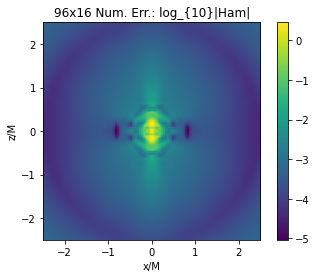

In [19]:
x96,y96,valuesCF96,valuesHam96 = np.loadtxt(os.path.join(outdir,'out96.txt')).T #Transposed for easier unpacking

pl_xmin = -2.5
pl_xmax = +2.5
pl_ymin = -2.5
pl_ymax = +2.5

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points96 = np.zeros((len(x96), 2))
for i in range(len(x96)):
    points96[i][0] = x96[i]
    points96[i][1] = y96[i]

grid96 = griddata(points96, valuesCF96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesCF96, (grid_x, grid_y), method='cubic')

grid96 = griddata(points96, valuesHam96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesHam96, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96x16 Num. Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("z/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

<Figure size 432x288 with 0 Axes>

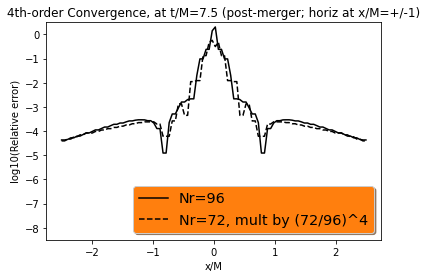

In [20]:
x72,y72,valuesCF72,valuesHam72 = np.loadtxt(os.path.join(outdir,'out72.txt')).T #Transposed for easier unpacking
points72 = np.zeros((len(x72), 2))
for i in range(len(x72)):
    points72[i][0] = x72[i]
    points72[i][1] = y72[i]

grid72 = griddata(points72, valuesHam72, (grid_x, grid_y), method='nearest')

griddiff_72_minus_96 = np.zeros((100,100))
griddiff_72_minus_96_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid72_1darray_yeq0 = np.zeros(100)
grid96_1darray_yeq0 = np.zeros(100)
count = 0
for i in range(100):
    for j in range(100):
        griddiff_72_minus_96[i][j] = grid72[i][j] - grid96[i][j]
        griddiff_72_minus_96_1darray[count] = griddiff_72_minus_96[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid72_1darray_yeq0[i] = grid72[i][j] + np.log10((72./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("4th-order Convergence, at t/M=7.5 (post-merger; horiz at x/M=+/-1)")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid72_1darray_yeq0, 'k--', label='Nr=72, mult by (72/96)^4')
ax.set_ylim([-8.5,0.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 9: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [21]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide")

Created Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.tex, and
    compiled LaTeX file to PDF file Tutorial-Start_to_Finish-
    BSSNCurvilinear-Two_BHs_Collide.pdf
